In [4]:
import os
import numpy as np
import h5py
import pandas as pd
import re  # To extract date from filenames
from scipy.spatial import cKDTree  # Efficient nearest neighbor search

# File paths
SMAP_data_dir = r'C:\Users\shiva\OneDrive - iitgn.ac.in\Desktop\CE Project\IN_Project\SMAP_L2_SM_P_E_0'
grid_file = r'C:\Users\shiva\OneDrive - iitgn.ac.in\Desktop\CE Project\India_SMAP_lalos.csv'
output_file = r'C:\Users\shiva\OneDrive - iitgn.ac.in\Desktop\CE Project\timedata_s.csv'

# Load India_SMAP_lalos.csv grid
grid_df = pd.read_csv(grid_file)
grid_lats = grid_df['Latitude'].values
grid_lons = grid_df['Longitude'].values

# Create a KDTree for fast nearest-neighbor lookup
grid_coords = np.column_stack((grid_lats, grid_lons))
tree = cKDTree(grid_coords)

# Define extent for latitude and longitude filtering
lat_min, lat_max = 5, 40
lon_min, lon_max = 65, 100

# List all .h5 files
h5_files = [f for f in os.listdir(SMAP_data_dir) if f.endswith('.h5')]

# Extract unique dates from filenames
date_pattern = re.compile(r'_(\d{8})T')  # Extracts "YYYYMMDD" from filenames
file_groups = {}

for file in h5_files:
    match = date_pattern.search(file)
    if match:
        date_str = match.group(1)  # Extract date (YYYYMMDD)
        if date_str not in file_groups:
            file_groups[date_str] = []
        file_groups[date_str].append(file)

# Initialize final DataFrame with grid structure
time_series_df = grid_df.copy()

# Process each group of files for a specific date
for date_str, files in file_groups.items():
    print(f"Processing files for date: {date_str}")
    
    # Dictionary to store accumulated soil moisture and counts for averaging
    soil_moisture_accumulated = {tuple(coord): 0 for coord in grid_coords}
    soil_moisture_counts = {tuple(coord): 0 for coord in grid_coords}

    # Read and process data for each file on this date
    for file in files:
        fname = os.path.join(SMAP_data_dir, file)
        with h5py.File(fname, 'r') as f:
            sm_data = f['Soil_Moisture_Retrieval_Data']
            lat, lon, soil_moisture = sm_data['latitude'][:], sm_data['longitude'][:], sm_data['soil_moisture'][:]
            
            # Flatten arrays and apply mask for the desired extent
            lat, lon, soil_moisture = lat.flatten(), lon.flatten(), soil_moisture.flatten()
            mask = (lon >= lon_min) & (lon <= lon_max) & (lat >= lat_min) & (lat <= lat_max)
            lat, lon, soil_moisture = lat[mask], lon[mask], soil_moisture[mask]
            
            # Replace negative values with NaN
            soil_moisture[soil_moisture < 0] = np.nan
            
            # Find nearest valid (lat, lon) for each data point
            data_coords = np.column_stack((lat, lon))
            _, indices = tree.query(data_coords)  # Find nearest neighbors in the grid
            matched_coords = grid_coords[indices]
            
            # Accumulate soil moisture values for the matched coordinates
            for i, key in enumerate(map(tuple, matched_coords)):
                if not np.isnan(soil_moisture[i]):
                    soil_moisture_accumulated[key] += soil_moisture[i]
                    soil_moisture_counts[key] += 1

    # Compute the final average soil moisture values
    averaged_soil_moisture = {
        key: soil_moisture_accumulated[key] / soil_moisture_counts[key]
        if soil_moisture_counts[key] > 0 else np.nan
        for key in soil_moisture_accumulated
    }
    
    # Convert results to a list matching the original grid order
    time_series_df[date_str] = [averaged_soil_moisture.get(tuple(coord), np.nan) for coord in grid_coords]
    print(f"Added data for {date_str}")

# Save the final time-series DataFrame to CSV
time_series_df.to_csv(output_file, index=False)
print(f"Final time-series file saved: {output_file}")

Processing files for date: 20160101
Added data for 20160101
Processing files for date: 20160102
Added data for 20160102
Processing files for date: 20160103
Added data for 20160103
Processing files for date: 20160104
Added data for 20160104
Processing files for date: 20160105
Added data for 20160105
Processing files for date: 20160106
Added data for 20160106
Processing files for date: 20160107
Added data for 20160107
Processing files for date: 20160108
Added data for 20160108
Processing files for date: 20160109
Added data for 20160109
Processing files for date: 20160110
Added data for 20160110
Processing files for date: 20160111
Added data for 20160111
Processing files for date: 20160112
Added data for 20160112
Processing files for date: 20160113
Added data for 20160113
Processing files for date: 20160114
Added data for 20160114
Processing files for date: 20160115
Added data for 20160115
Processing files for date: 20160116
Added data for 20160116
Processing files for date: 20160117
Adde

Plotting soil moisture for date: 20160101


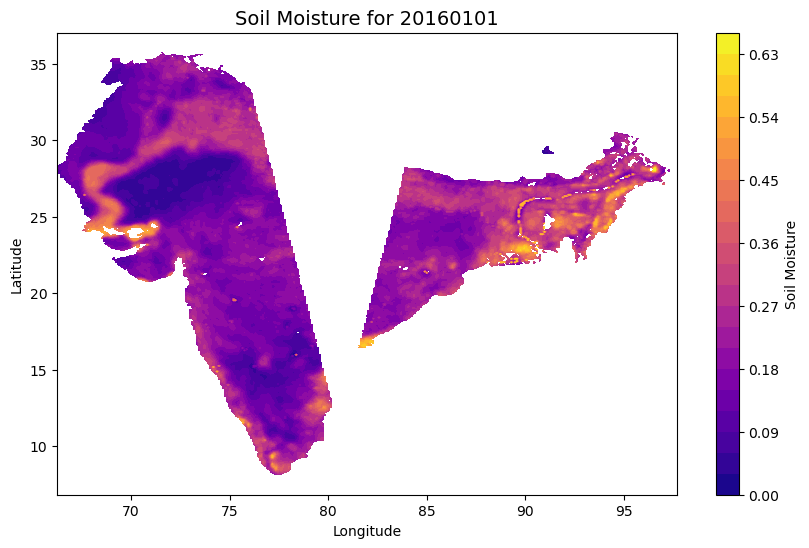

Plotting soil moisture for date: 20160102


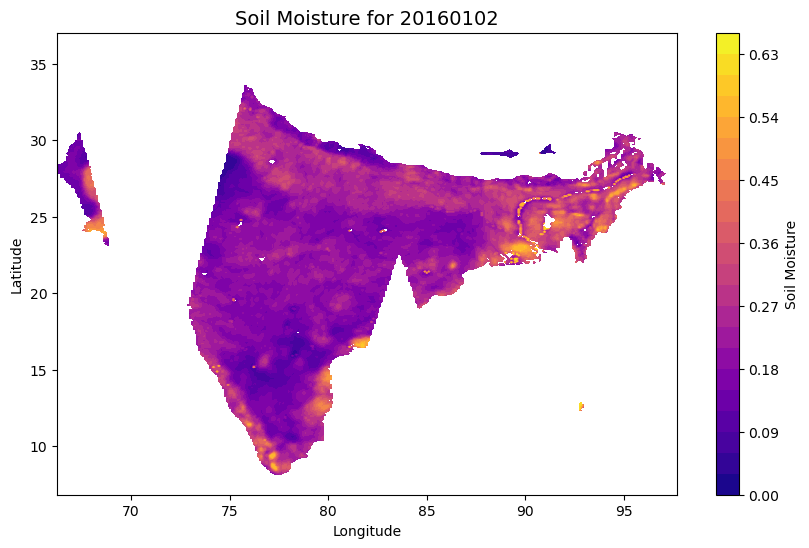

Plotting soil moisture for date: 20160103


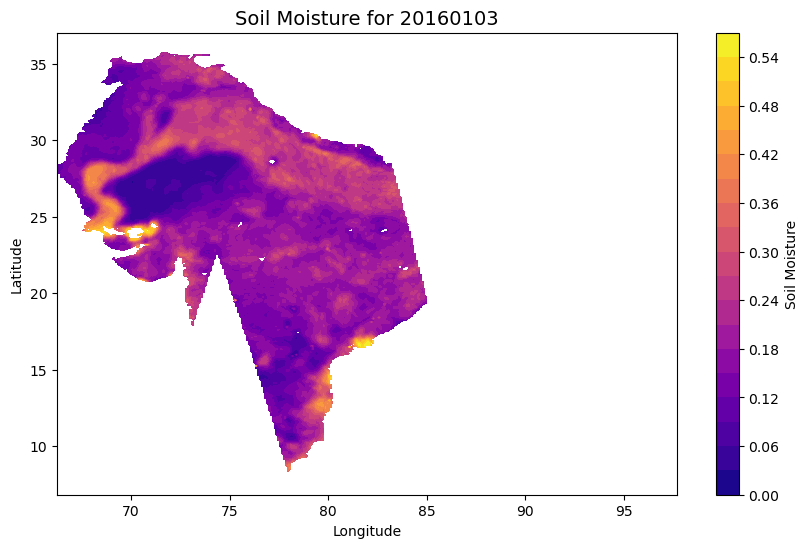

Plotting soil moisture for date: 20160104


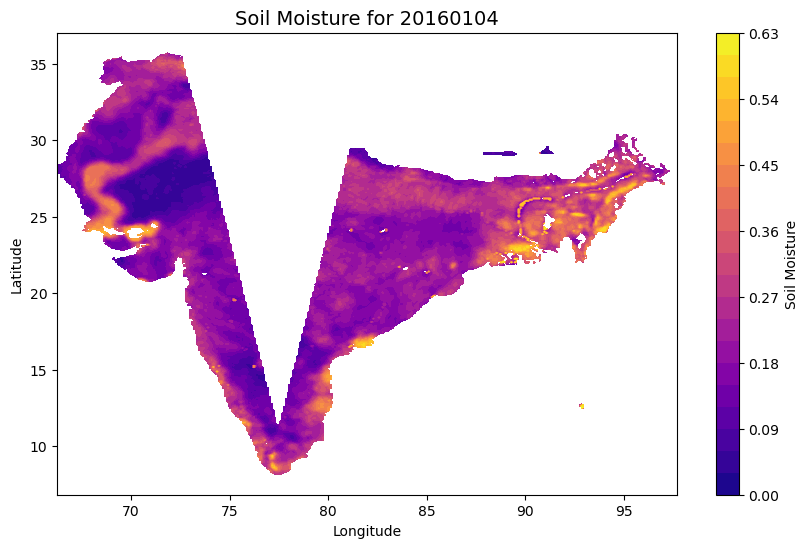

Plotting soil moisture for date: 20160105


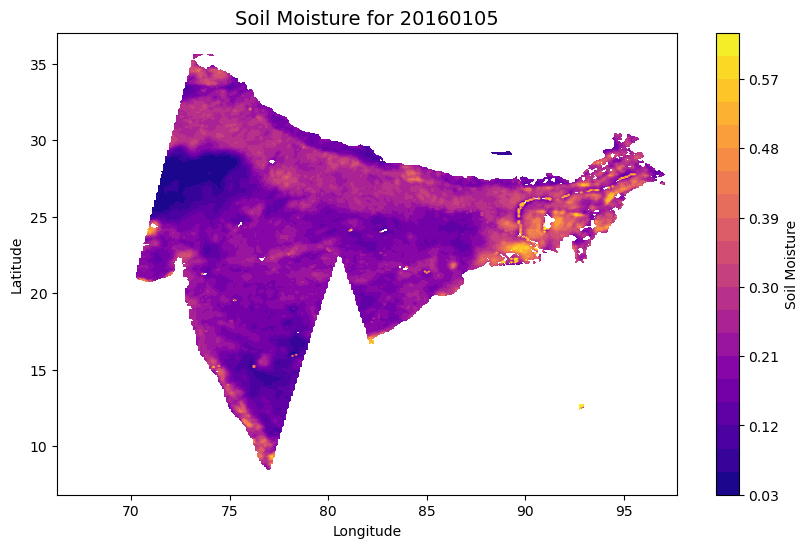

Plotting soil moisture for date: 20160106


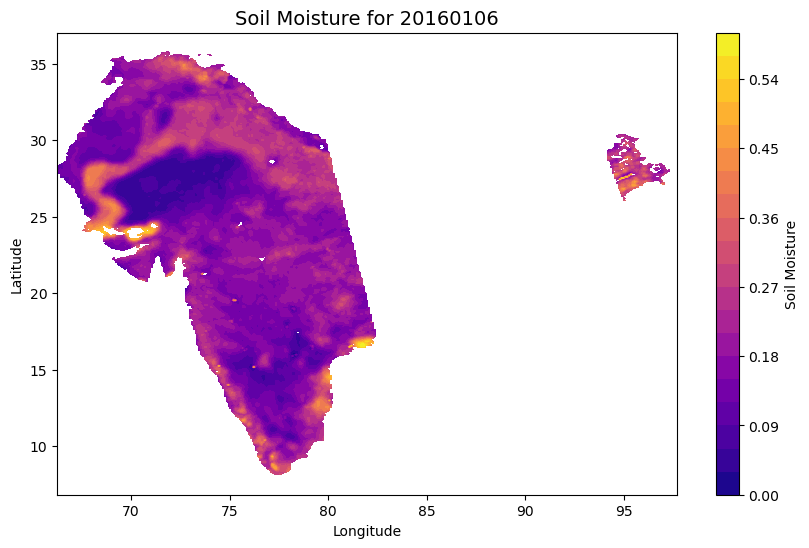

All plots generated successfully.


In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm

# File path to the time-series data
time_series_file = r'C:\Users\shiva\OneDrive - iitgn.ac.in\Desktop\CE Project\timedata_s.csv'

# Read the time-series data
time_series_df = pd.read_csv(time_series_file)

# Extract latitude and longitude values
latitudes = time_series_df['Latitude'].values
longitudes = time_series_df['Longitude'].values

def plot_soil_moisture(date_str, latitudes, longitudes, soil_moisture_values):
    unique_lats = np.unique(latitudes)
    unique_lons = np.unique(longitudes)
    lon_grid, lat_grid = np.meshgrid(unique_lons, unique_lats)
    soil_moisture_grid = np.full(lon_grid.shape, np.nan)

    for lat, lon, sm in zip(latitudes, longitudes, soil_moisture_values):
        lat_idx = np.where(unique_lats == lat)[0][0]
        lon_idx = np.where(unique_lons == lon)[0][0]
        soil_moisture_grid[lat_idx, lon_idx] = sm

    plt.figure(figsize=(10, 6))
    plt.contourf(lon_grid, lat_grid, soil_moisture_grid, 20, cmap=cm.plasma)
    plt.colorbar(label='Soil Moisture')
    plt.title(f"Soil Moisture for {date_str}", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Loop through each date column and plot the corresponding soil moisture data
count = 0
for date_str in time_series_df.columns[2:]:  # Skipping Latitude and Longitude columns
    if count>5:
        break
    print(f"Plotting soil moisture for date: {date_str}")
    soil_moisture_values = time_series_df[date_str].values
    plot_soil_moisture(date_str, latitudes, longitudes, soil_moisture_values)
    count+=1

print("All plots generated successfully.")


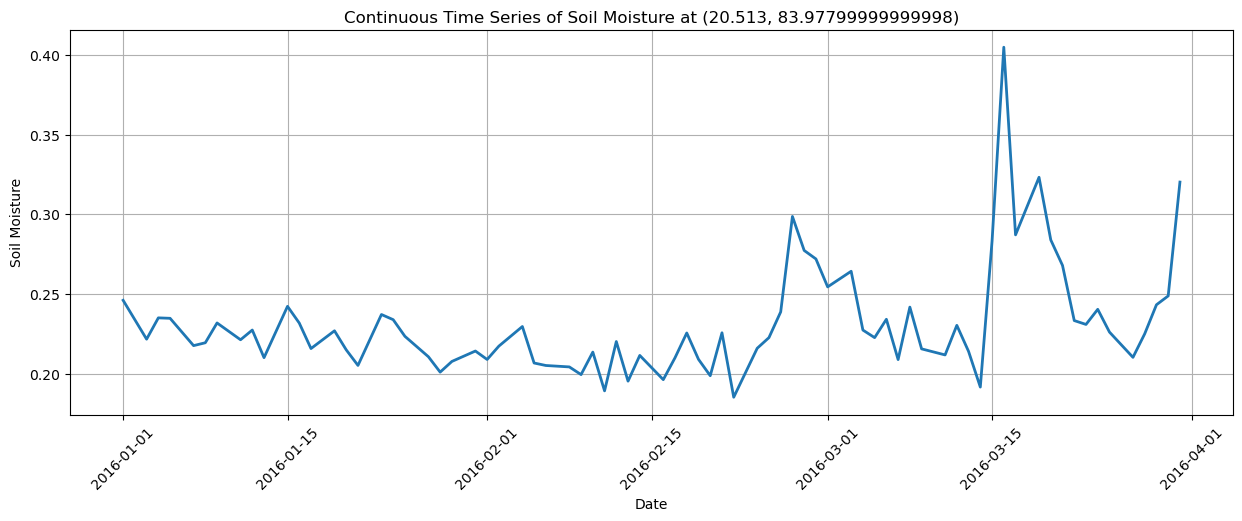

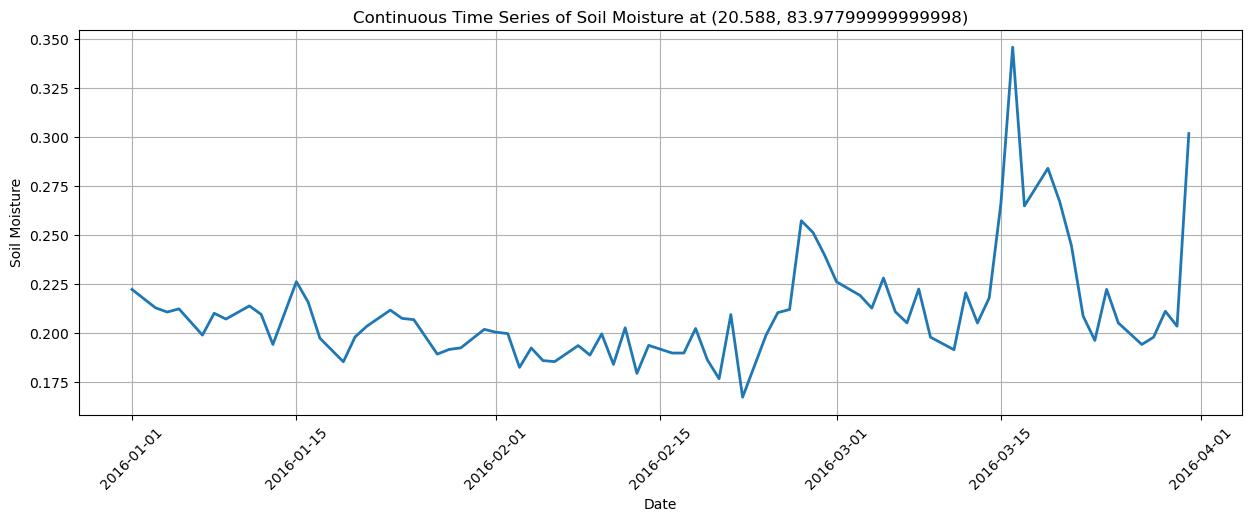

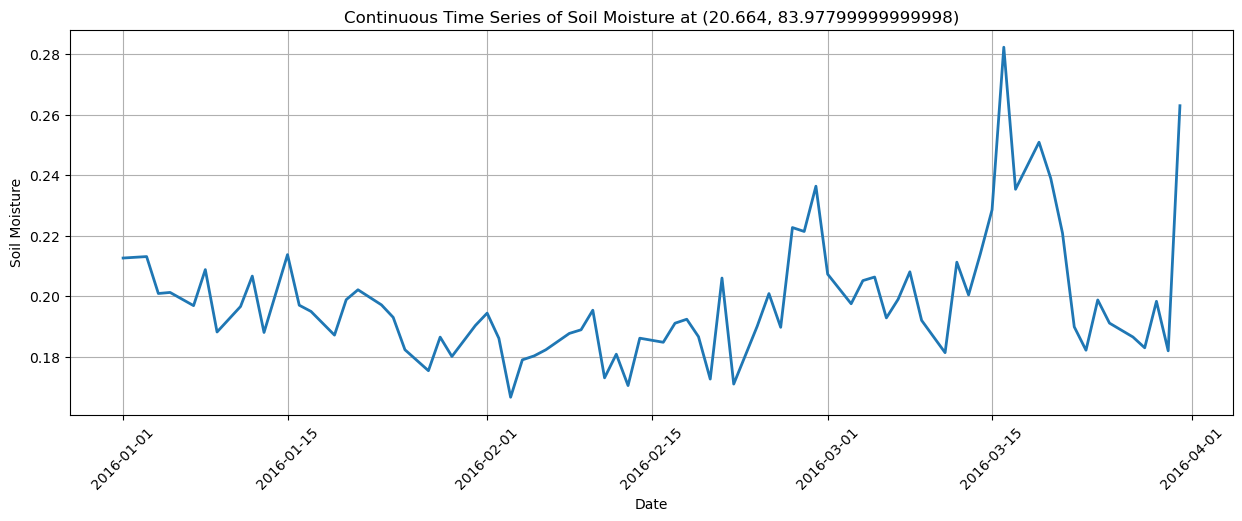

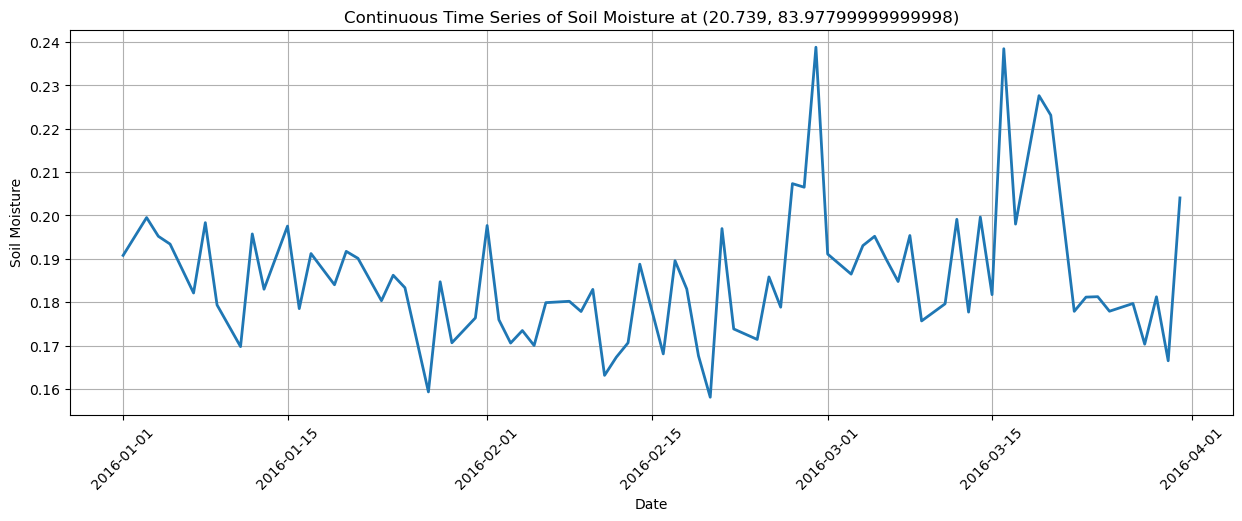

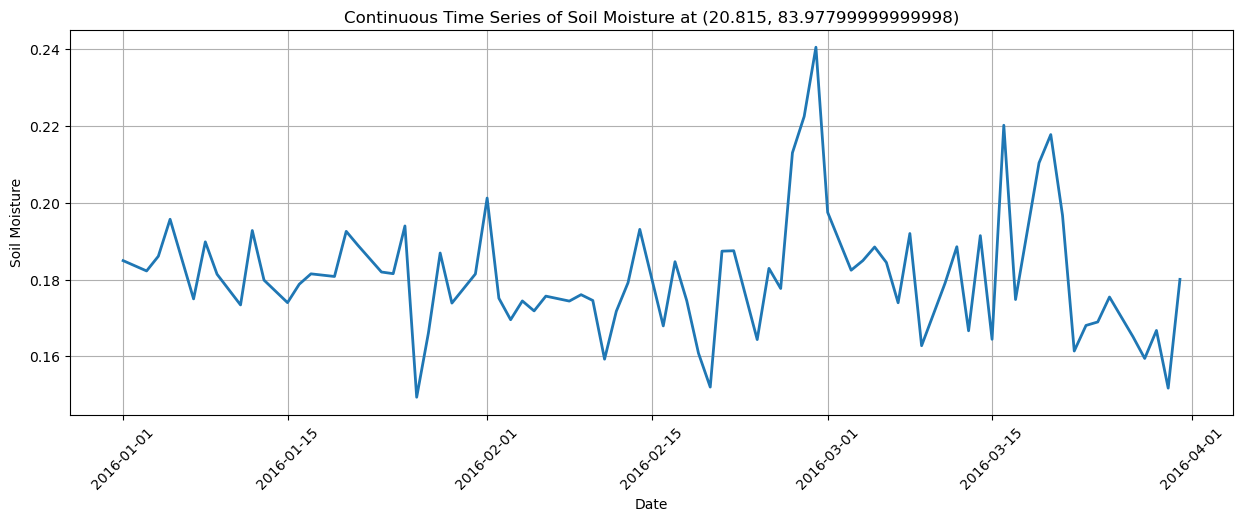

In [6]:
# File path to the time-series data
time_series_file = r'C:\Users\shiva\OneDrive - iitgn.ac.in\Desktop\CE Project\timedata_s.csv'

# Read the time-series data
time_series_df = pd.read_csv(time_series_file)

# Extract latitude and longitude values
latitudes = time_series_df['Latitude'].values
longitudes = time_series_df['Longitude'].values

# Function to plot continuous time series for each coordinate, interpolating missing values
def plot_time_series(lat, lon):
    mask = (time_series_df['Latitude'] == lat) & (time_series_df['Longitude'] == lon)
    if mask.sum() == 0:
        print(f"No data found for coordinate ({lat}, {lon})")
        return
    
    time_series = time_series_df.loc[mask].iloc[0, 2:].copy()
    time_series.index = pd.to_datetime(time_series.index, format='%Y%m%d')
    time_series = time_series.astype(float)
    
    # Interpolate missing values to follow trend
    time_series.interpolate(method='linear', inplace=True)
    
    plt.figure(figsize=(15, 5))
    plt.plot(time_series.index, time_series.values, linestyle='-', linewidth=2)
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Soil Moisture")
    plt.title(f"Continuous Time Series of Soil Moisture at ({lat}, {lon})")
    plt.grid()
    plt.show()

# Example: Plot time series for a specific coordinate
for i in range(0,5):
    example_lat, example_lon = latitudes[i], longitudes[i]
    plot_time_series(example_lat, example_lon)



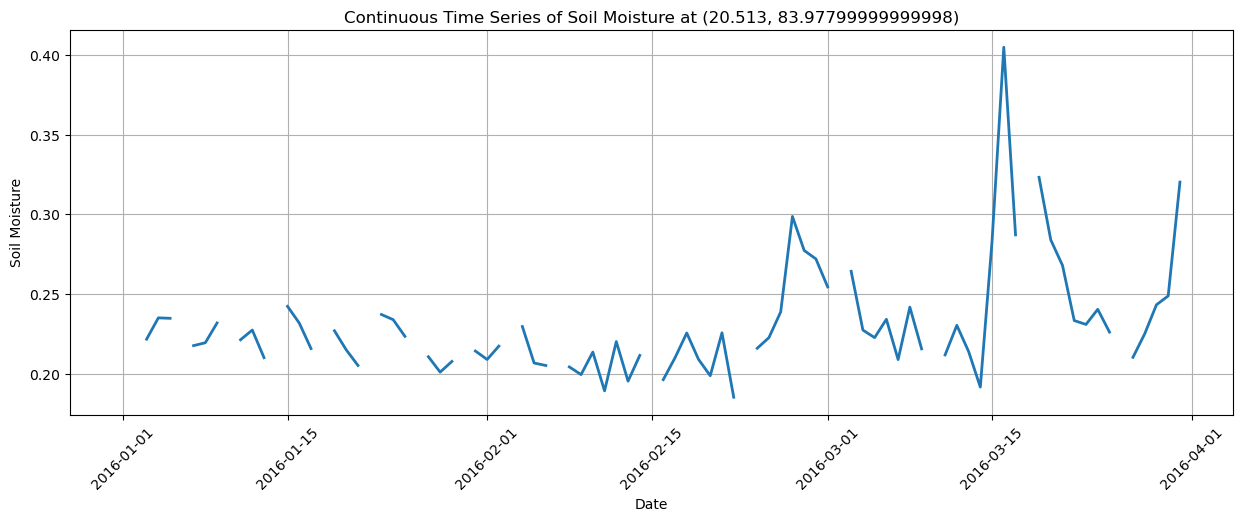

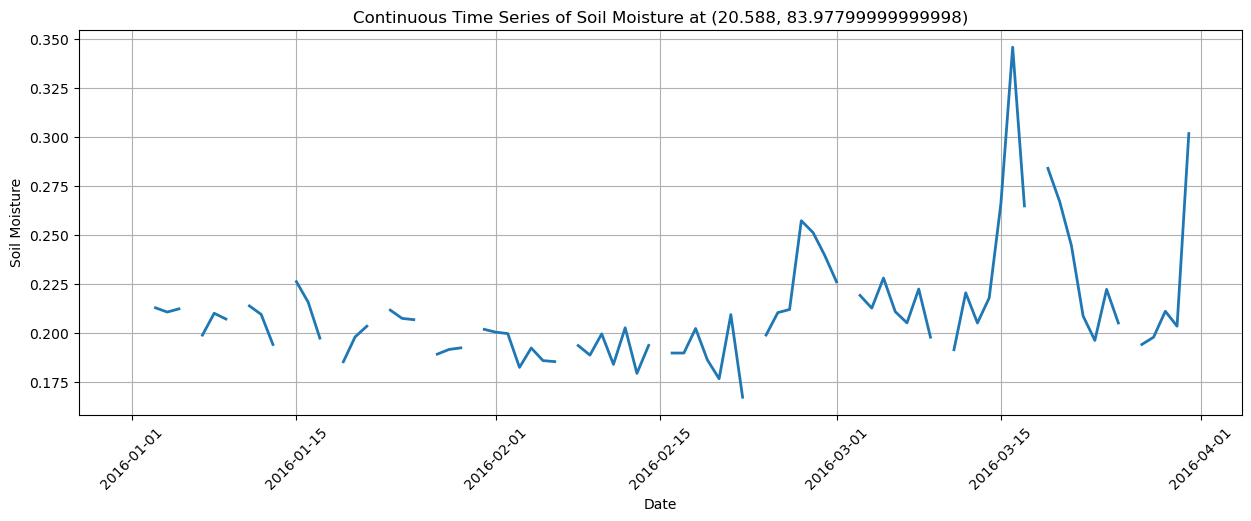

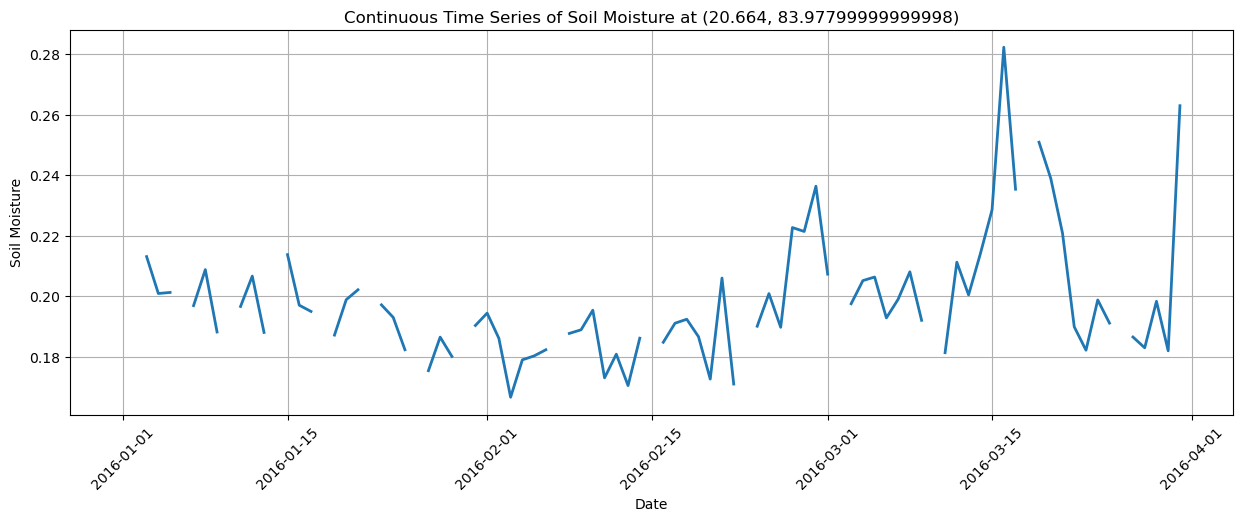

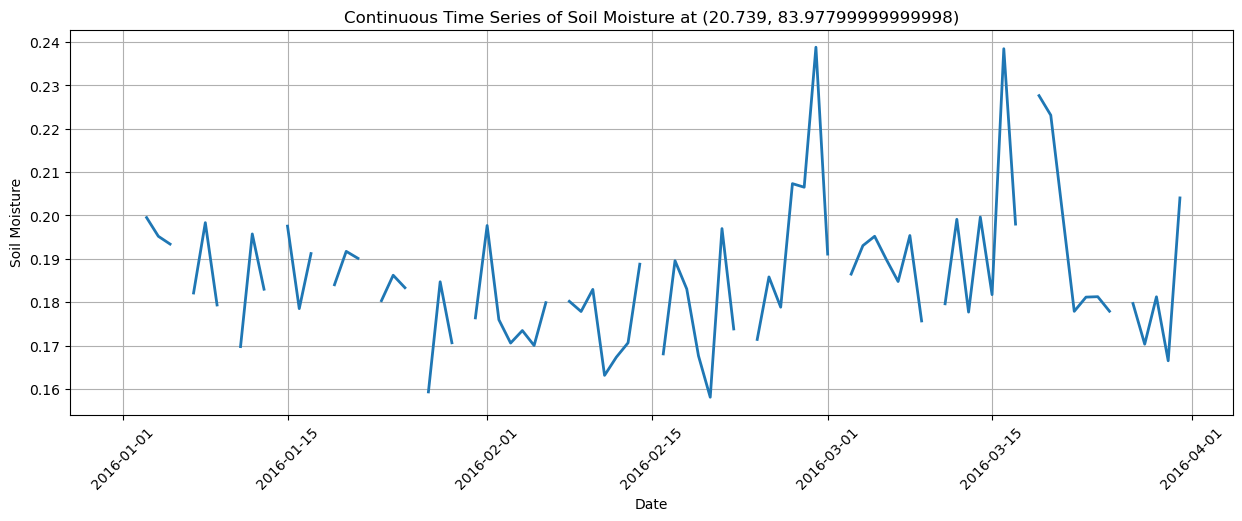

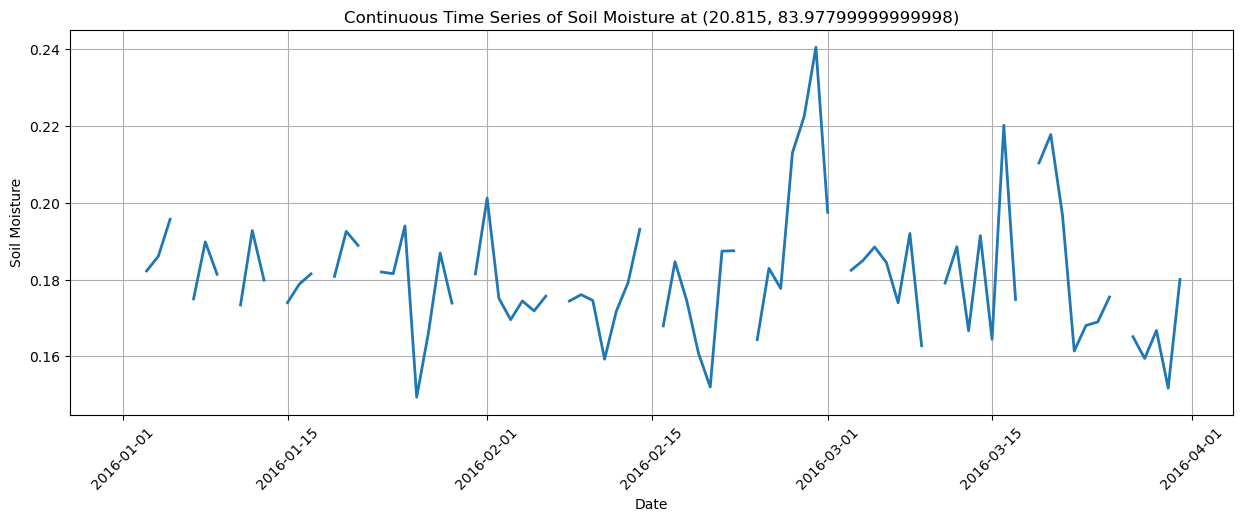

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File path to the time-series data
time_series_file = r'C:\Users\shiva\OneDrive - iitgn.ac.in\Desktop\CE Project\timedata_s.csv'

# Read the time-series data
time_series_df = pd.read_csv(time_series_file)

# Extract latitude and longitude values
latitudes = time_series_df['Latitude'].values
longitudes = time_series_df['Longitude'].values

# Function to plot continuous time series for each coordinate without interpolation
def plot_time_series(lat, lon):
    mask = (time_series_df['Latitude'] == lat) & (time_series_df['Longitude'] == lon)
    if mask.sum() == 0:
        print(f"No data found for coordinate ({lat}, {lon})")
        return
    
    time_series = time_series_df.loc[mask].iloc[0, 2:].copy()
    time_series.index = pd.to_datetime(time_series.index, format='%Y%m%d')
    time_series = time_series.astype(float)
    
    plt.figure(figsize=(15, 5))
    plt.plot(time_series.index, time_series.values, linestyle='-', linewidth=2)
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Soil Moisture")
    plt.title(f"Continuous Time Series of Soil Moisture at ({lat}, {lon})")
    plt.grid()
    plt.show()

# Example: Plot time series for a specific coordinate
for i in range(0, 5):
    example_lat, example_lon = latitudes[i], longitudes[i]
    plot_time_series(example_lat, example_lon)

In [10]:

# File path to the time-series data
time_series_file = r'C:\Users\shiva\OneDrive - iitgn.ac.in\Desktop\CE Project\timedata_s.csv'

# Read the time-series data
time_series_df = pd.read_csv(time_series_file)

# Find the coordinate with the highest average soil moisture over all days
time_series_values = time_series_df.iloc[:, 2:].mean(axis=1)
max_index = time_series_values.idxmax()
highest_lat = time_series_df.loc[max_index, 'Latitude']
highest_lon = time_series_df.loc[max_index, 'Longitude']
highest_value = time_series_values[max_index]

print(f"Coordinate with highest average soil moisture: ({highest_lat}, {highest_lon})")
print(f"Highest average soil moisture value: {highest_value}")

Coordinate with highest average soil moisture: (27.775, 92.661)
Highest average soil moisture value: 0.6161759346723557
